# Baroclinic Instability Test

Dynamical core test. Model is first tested on analytic steady state solution to the primitive equations. Afterwards, a perturbation is added and the baroclinic evolution of the wave is observed.

Jablonowski, C. and Williamson, D.L., 2006. A baroclinic instability test case for atmospheric model dynamical cores. Quarterly Journal of the Royal Meteorological Society: A journal of the atmospheric sciences, applied meteorology and physical oceanography, 132(621C)

In [1]:
import numpy as np
import tensorflow as tf

import TensorDynamics.model_def as md

import TensorDynamics.constants as constants

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Creation of the dynamical model object

In [2]:

# Define some parameters of the model
nlevels=20 # number of vertical levels
trunc=85 # spectral truncation limit
nlats=128 # number of gaussian latitudes

# create the atmospheric model
int_type="leap"
model=md.model(nlats,trunc,nlevels,int_type=int_type)

# Plot fields as close as possible to the 850 hPa sigma level
plot_ind=np.argsort(np.abs(model.sigmas-0.85))[0]
print(model.sigmas[plot_ind])
days=10
runtime=24*days # hours

# create arrays for lats, lons, sigmas for ease of use
lats=model.f_obj.lats
wlats=lats[None,:,None] # wide lats array for broadcasting
lons=model.f_obj.lons
wlons=lons[None,None,:] # wide lons array for broadcasting
sigmas=model.sigmas
wsigmas=model.sigmas[:,None,None] # wide sigmas array for broadcasting


tf.Tensor(0.875, shape=(), dtype=float32)


## Creation of the steady state

In [3]:
# some constants
A_EARTH=constants.A_EARTH
U0=35 #m/s
OMEGA=constants.OMEGA # angular velocity
GRAV=constants.GRAVITY_ACC
R=constants.DRY_AIR_CONST # gas constant
TAU=0.005
T0=288 # kelvin
delta_T=4.8*(10**5)

# initial zonal and meridional wind
nv=(wsigmas-0.252)*np.pi/2
tmp1=tf.math.cos(nv)**1.5
tmp2=tf.math.sin(2*wlats)**2
u_init=tf.constant(U0*tmp1*tmp2*tf.ones_like(lons),dtype=np.single)
v_init=tf.zeros_like(u_init)

# wind perturbation
latC=2*np.pi/9
lonC=np.pi/9
distance = A_EARTH * tf.math.acos(tf.math.sin(latC)*tf.math.sin(wlats)+tf.math.cos(latC)*tf.math.cos(wlats)*tf.math.cos(wlons-lonC))
u_pert= tf.math.exp(-(10*distance/A_EARTH)**2)

# initial temperature
T_lower=np.array(T0 * tf.pow(wsigmas,R*TAU/GRAV))
T_lower[sigmas<0.2]+=(delta_T*tf.pow(0.2-wsigmas,5))[sigmas<0.2]
T_lower=tf.constant(T_lower,dtype=np.single)
u_tmp=(U0*tf.math.cos(nv)**1.5)

T_init=0.75*wsigmas*np.pi*U0/R *tf.math.sin(nv)*tf.math.cos(nv)**0.5
T_init=T_init*((-2*(1/3+tf.math.cos(wlats)**2)*tf.math.sin(wlats)**6+10/63)*2*u_tmp+
					(8/5*(tf.math.sin(wlats)**2+2/3)*tf.math.cos(wlats)**3-np.pi/4)*A_EARTH*OMEGA)

T_init= (T_init+T_lower)*tf.ones_like(lons)


# surface geopotential
u_tmp=(U0*tf.math.cos((1-0.252)*np.pi/2)**1.5)
geopot_surface=0*T0*GRAV/TAU +u_tmp*((-2*(1/3+tf.math.cos(lats)**2)*tf.math.sin(lats)**6+10/63)*u_tmp+
					(8/5*(tf.math.sin(lats)**2+2/3)*tf.math.cos(lats)**3-np.pi/4)*A_EARTH*OMEGA)
geopot_surface=geopot_surface[None,:,None]*tf.ones_like(lons)


# surface pressure
PS=(tf.ones(shape=(1,len(lats),len(lons)),dtype=np.single)*100000)

# create dictionaries for the steady state initial conditions and the perturbed initial conditions
steady_state={"surface_pressure":PS,"temperature":T_init,"specific_humidity":T_init*0,
	"u_component_of_wind":u_init,"v_component_of_wind":v_init,"geopotential_at_surface":geopot_surface}

perturbed_state={"surface_pressure":PS,"temperature":T_init,"specific_humidity":T_init*0,
	"u_component_of_wind":u_init+u_pert,"v_component_of_wind":v_init,"geopotential_at_surface":geopot_surface,}

# calculate vorticity for the steady state
steady_state_amn = model.encode(steady_state)
vort_init=model.f_obj.eval(model.f_obj.laplacian(steady_state_amn["psi_amn"])*A_EARTH**2,model.f_obj.legfuncs)

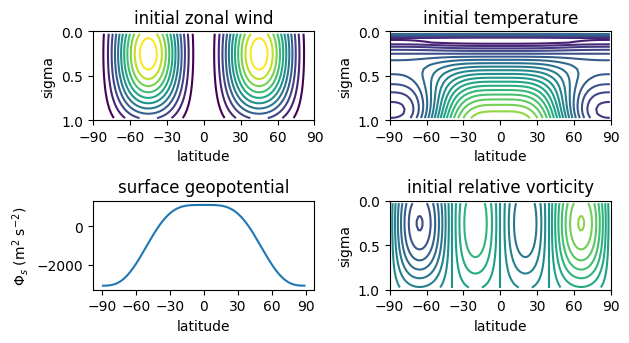

In [4]:
latsDeg = lats*180/np.pi
plt.figure()

# plot steady state zonal wind
plt.subplot(3,2,1)
plt.contour(latsDeg,sigmas,u_init[:,:,0],levels=np.arange(3,36,3))
plt.title("initial zonal wind")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

# plot steady state temperature
plt.subplot(3,2,2)
plt.title("initial temperature")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.contour(latsDeg,sigmas,T_init[:,:,0],levels=np.arange(205,330,5))
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

# plot surface geopotential
plt.subplot(3,2,3)
plt.plot(latsDeg,geopot_surface[0,:,0])
plt.title("surface geopotential")
plt.xlabel("latitude")
plt.ylabel(r"$\Phi_s$ (m$^2$ s$^{-2}$)")
plt.xticks(np.arange(-90,91,30))

# plot steady state vorticity
plt.subplot(3,2,4)
plt.contour(latsDeg,sigmas,vort_init[:,:,0],levels=np.arange(-3,3,0.25)*(1e-5))
plt.title("initial relative vorticity")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

plt.tight_layout()

## Integrate Forward from Steady State

In [5]:
evolved_state=model.stepper(runtime,steady_state)


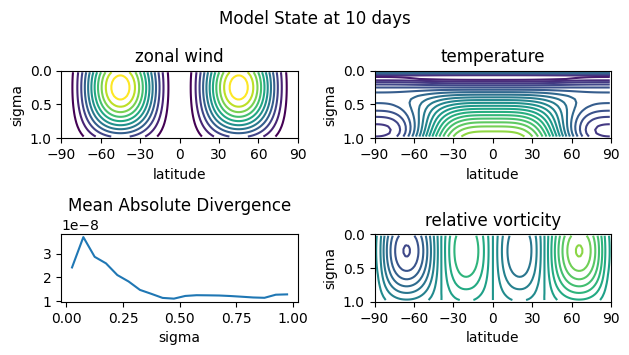

In [6]:
# calculate vorticity and divergence at the end of the model simulation
evolved_state_amn = model.encode(evolved_state)
evolved_vort=model.f_obj.eval(model.f_obj.laplacian(evolved_state_amn["psi_amn"])*A_EARTH**2,model.f_obj.legfuncs)
evolved_div=model.f_obj.eval(model.f_obj.laplacian(evolved_state_amn["chi_amn"])*A_EARTH**2,model.f_obj.legfuncs)


plt.figure()

# plot model zonal wind
plt.subplot(3,2,1)
plt.contour(latsDeg,sigmas,evolved_state["u_component_of_wind"][:,:,0],levels=np.arange(3,36,3))
plt.title("zonal wind")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])


# plot model temperature
plt.subplot(3,2,2)
plt.title("temperature")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.contour(latsDeg,sigmas,evolved_state["temperature"][:,:,0],levels=np.arange(205,330,5))
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

# plot mean absolute value of divergence on each sigma level
plt.subplot(3,2,3)
weighted_div=np.abs(evolved_div)*np.cos(wlats)
total_weights=np.cos(wlats)*np.ones(len(lons))
plt.plot(sigmas,np.sum(weighted_div,axis=(1,2))/np.sum(total_weights))
plt.title("Mean Absolute Divergence")
plt.xlabel("sigma")

# plot model relative vorticity
plt.subplot(3,2,4)
plt.contour(latsDeg,sigmas,evolved_vort[:,:,0],levels=np.arange(-3,3,0.25)*(1e-5))
plt.title("relative vorticity")
plt.xlabel("latitude")
plt.ylabel("sigma")
plt.xticks(np.arange(-90,91,30))
plt.ylim([1, 0])

plt.suptitle("Model State at " +str(days)+" days")
plt.tight_layout()

As expected, the model state is visually indistinguishable from the analytic steady state. Mean absolute value of divergence is near zero at each level.

## Perturbation experiment

In [7]:
# This time, save a history of the model states every 24 hours
perturbed_evolved_state,history=model.stepper(runtime,perturbed_state,output_interval=24)


Now plot anomalies (differences from steady state) at 850 hPa sigma level

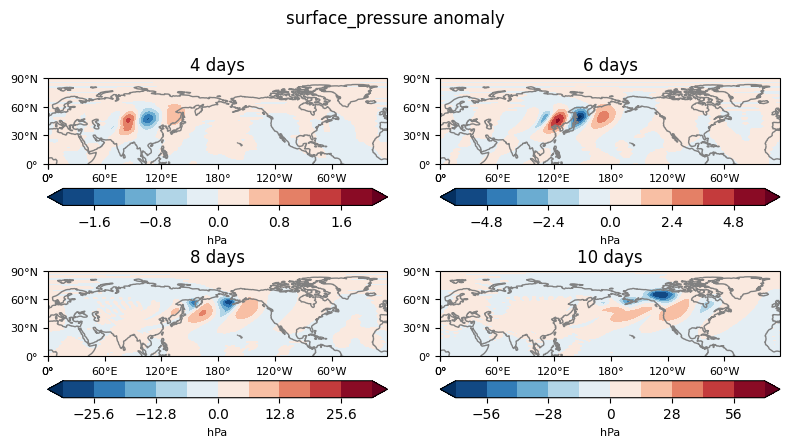

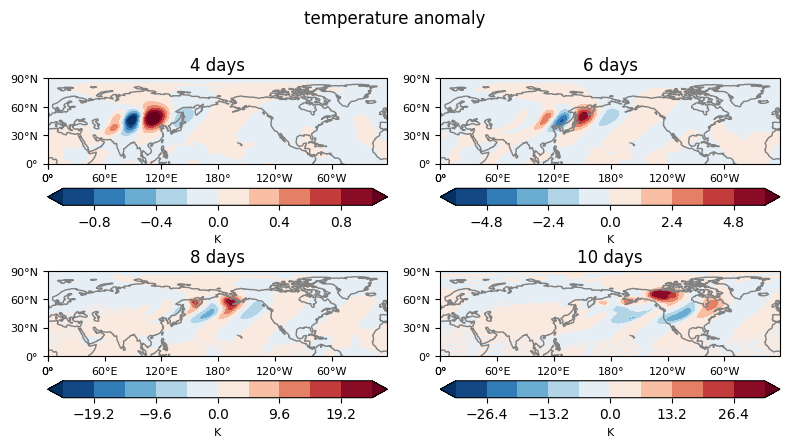

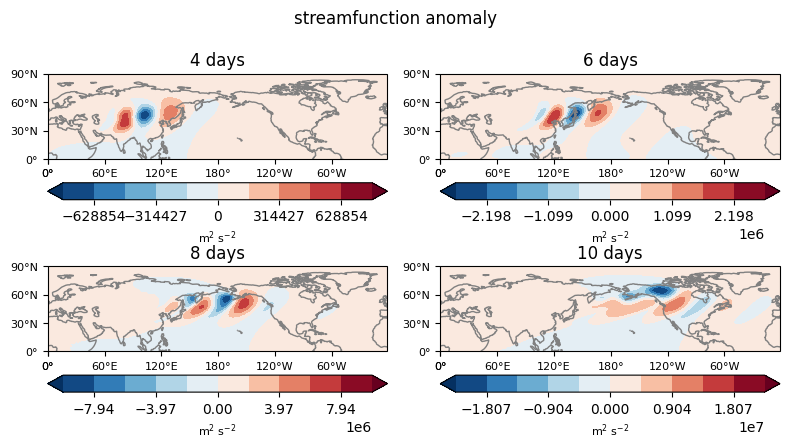

In [8]:
cl=180
proj = ccrs.PlateCarree(central_longitude=cl)

# create plots for surface pressure, temperature, and streamfunction for different lead times
plot_days=[4,6,8,10]
units=["hPa","K",r"m$^2$ s$^{-2}$"]
for j,varname in enumerate(["surface_pressure","temperature","streamfunction"]):
	
	fig , axes=plt.subplots(nrows=2,ncols=2,figsize=[8,4.5],squeeze=False,subplot_kw=dict(projection=proj))
	
	for i,plot_day in enumerate(plot_days):

		# calculate deviation from steady state
		field=history[plot_day][varname]-model.decode(model.encode(steady_state))[varname]
		if varname=="surface_pressure":
			field=field[0]/100 # convert to hPa
		else:
			field=field[plot_ind]
		
		ax=axes[int(i/2)][i%2]

		mag=np.round(np.nanmax(np.abs(field)))
		if mag==0:
			mag=0.1

		levels=np.linspace(-mag,mag,num=11)

		im=ax.contourf(lons*180/np.pi,lats*180/np.pi,field,levels=levels,transform=ccrs.PlateCarree(),cmap="RdBu_r",extend='both')
		
		ax.coastlines(color="gray")
		ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
		ax.set_yticks([0, 30, 60, 90], crs=ccrs.PlateCarree())
		ax.set_title(str(plot_day)+" days")
		lon_formatter = LongitudeFormatter()
		lat_formatter = LatitudeFormatter()
		ax.xaxis.set_major_formatter(lon_formatter)
		ax.yaxis.set_major_formatter(lat_formatter)
		ax.tick_params(labelsize=8)
		ax.set_ylim([0,90])

		cbar=plt.colorbar(im,orientation="horizontal")
		cbar.set_label(label=units[j],size=8)
		
	plt.suptitle(varname+" anomaly")
	plt.tight_layout(rect=[0,0,1,1])


Now plot anomalies (differences from steady state) for vertical crossections at the initial latitude of the disturbance

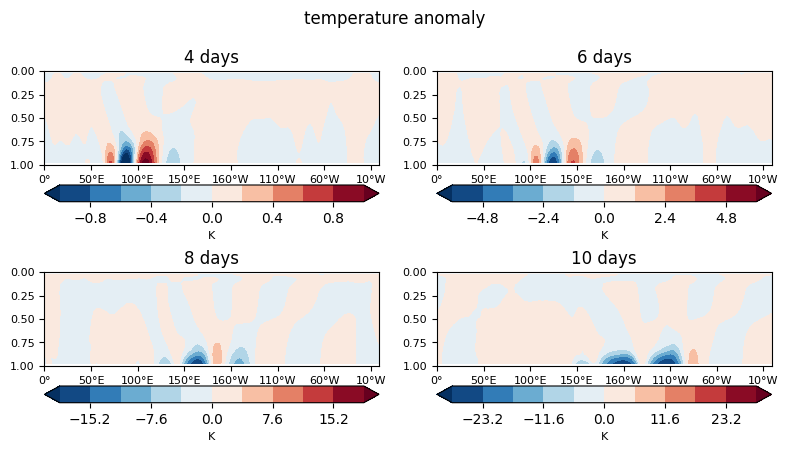

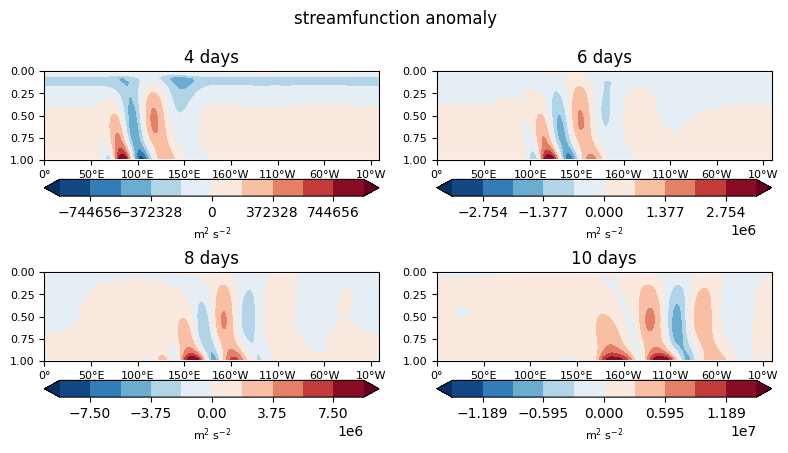

In [9]:
####################################################################

lat_ind=np.argsort(np.abs(lats-latC))[0]


plot_days=[4,6,8,10]
units=["K",r"m$^2$ s$^{-2}$"]
for j,varname in enumerate(["temperature","streamfunction"]):
	fig , axes=plt.subplots(nrows=2,ncols=2,figsize=[8,4.5],squeeze=False)
	for i,plot_day in enumerate(plot_days):
		field=history[plot_day][varname]-model.decode(model.encode(steady_state))[varname]


		field=np.mean(field[:,lat_ind-2:lat_ind+2,:],axis=1)
		ax=axes[int(i/2)][i%2]

		mag=np.round(np.max(np.abs(field)))
		if mag==0:
			mag=0.1

		levels=np.linspace(-mag,mag,num=11)


		im=ax.contourf(lons*180/np.pi,sigmas,field,levels=levels,cmap="RdBu_r",extend='both')
		

		ax.set_title(str(plot_day)+" days")
		lon_formatter = LongitudeFormatter()
		ax.xaxis.set_major_formatter(lon_formatter)
		ax.tick_params(labelsize=8)
		ax.set_ylim([1,0])

		cbar=plt.colorbar(im,orientation="horizontal")
		cbar.set_label(label=units[j],size=8)
		
	plt.suptitle(varname+" anomaly")
	plt.tight_layout(rect=[0,0,1,1])
